# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


Quick glance at how many entries of each label (Navigational Status) are in the dataset.

In [10]:
import os
import pandas as pd

# Load Data
folder_path = "area_vessels"
files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Combine data from all CSVs
data = []
for file in files:
    print(f"Loading file: {file}")  # Debugging: Print file being processed
    df = pd.read_csv(file, comment='#')
    data.append(df[['Navigational status']])
data = pd.concat(data)

# Drop missing Navigational Status values if any
if data['Navigational status'].isna().sum() > 0:
    print(f"Warning: Found {data['Navigational status'].isna().sum()} missing entries for Navigational status. Dropping them.")
    data = data.dropna(subset=['Navigational status'])

# Summarize the counts for each Navigational Status
status_counts = data['Navigational status'].value_counts()

# Print the summary
print("\nNavigational Status Counts:")
print(status_counts)


Loading file: area_vessels/mmsi_374689000.csv
Loading file: area_vessels/mmsi_205689000.csv
Loading file: area_vessels/mmsi_219033037.csv
Loading file: area_vessels/mmsi_246396000.csv
Loading file: area_vessels/mmsi_211405010.csv
Loading file: area_vessels/mmsi_563223700.csv
Loading file: area_vessels/mmsi_211219990.csv
Loading file: area_vessels/mmsi_314603000.csv
Loading file: area_vessels/mmsi_219028116.csv
Loading file: area_vessels/mmsi_211570140.csv
Loading file: area_vessels/mmsi_211379770.csv
Loading file: area_vessels/mmsi_211297990.csv
Loading file: area_vessels/mmsi_211211850.csv
Loading file: area_vessels/mmsi_219026261.csv
Loading file: area_vessels/mmsi_219023116.csv
Loading file: area_vessels/mmsi_211779530.csv
Loading file: area_vessels/mmsi_211158000.csv
Loading file: area_vessels/mmsi_219000176.csv
Loading file: area_vessels/mmsi_219029708.csv
Loading file: area_vessels/mmsi_211385020.csv
Loading file: area_vessels/mmsi_211440370.csv
Loading file: area_vessels/mmsi_22

## Model Choice

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]
For multi-class classification: Linear regression is not suitable at all. Methods like one-vs-rest (OvR) logistic regression, decision trees, or support vector machines should be considered instead.


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


In [5]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
folder_path = "area_vessels"
files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Combine data from all CSVs
data = []
for file in files:
    df = pd.read_csv(file, comment='#')
    data.append(df[['Timestamp', 'Latitude', 'Longitude', 'SOG', 'COG', 'Heading', 'Navigational status']])
data = pd.concat(data)

# Convert Timestamp to datetime
print("Converting Timestamp to datetime...")
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
missing_timestamps = data['Timestamp'].isna().sum()
if missing_timestamps > 0:
    print(f"Warning: {missing_timestamps} rows have invalid timestamps and will be dropped.")
data = data.dropna(subset=['Timestamp'])
print(f"Total rows after dropping invalid timestamps: {len(data)}")  # Debugging: Check rows after cleaning

# Filter Data for Timeslot (30 minutes)
timeslot_minutes = 30
data = data.sort_values('Timestamp')
data['Time_Group'] = (data['Timestamp'] - data['Timestamp'].min()).dt.total_seconds() // (timeslot_minutes * 60)

# Debugging: Verify time group creation
print("First few rows of Time_Group column:")
print(data[['Timestamp', 'Time_Group']].head())

# Aggregate Features
grouped = data.groupby('Time_Group').agg({
    'Latitude': ['mean', 'std'],
    'Longitude': ['mean', 'std'],
    'SOG': ['mean', 'std'],
    'COG': ['mean', 'std'],
    'Heading': ['mean', 'std'],
    'Navigational status': 'first'  # Assume the status doesn't change in the timeslot
}).dropna()  # Drop any incomplete groups

# Flatten MultiIndex Columns
grouped.columns = ['_'.join(col).strip() for col in grouped.columns]
grouped.reset_index(drop=True, inplace=True)

# Debugging: Check aggregated data
print(f"Aggregated data contains {len(grouped)} groups.")
print("Sample of the aggregated dataset:")
print(grouped.head(3))

# Check if any Time_Groups are skipped
expected_groups = len(data['Time_Group'].unique())
actual_groups = len(grouped)
if expected_groups != actual_groups:
    print(f"Warning: Mismatch in expected groups ({expected_groups}) and aggregated groups ({actual_groups}).")
else:
    print(f"All Time_Groups accounted for: {actual_groups} groups.")

# Split Features and Target
X = grouped.drop(columns=['Navigational status_first'])
y = grouped['Navigational status_first']

# Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

Converting Timestamp to datetime...
Total rows after dropping invalid timestamps: 230960
First few rows of Time_Group column:
            Timestamp  Time_Group
0 2024-11-26 00:00:00         0.0
1 2024-11-26 00:00:00         0.0
2 2024-11-26 00:00:00         0.0
3 2024-11-26 00:00:00         0.0
0 2024-11-26 00:00:01         0.0
Aggregated data contains 48 groups.
Sample of the aggregated dataset:
   Latitude_mean  Latitude_std  Longitude_mean  Longitude_std  SOG_mean  \
0      55.691212      0.596924       10.057206       1.273444  4.892486   
1      55.559636      0.713390       10.675422       1.082180  6.460050   
2      55.395372      0.748374       10.728765       1.110494  6.807326   

    SOG_std    COG_mean    COG_std  Heading_mean  Heading_std  \
0  4.968039  171.103293  86.594705    190.740254    66.232303   
1  5.852309  177.430365  75.772385    179.576905    70.309227   
2  5.978329  203.631039  82.884488    209.075085    77.046797   

  Navigational status_first  
0    Und

## Implementation

[Implement your baseline model here.]



In [6]:
# Build the Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer with softmax
])

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)





Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-30 21:24:57.588349: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 1.1299 - val_accuracy: 0.3750 - val_loss: 1.0355
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3000 - loss: 1.1326 - val_accuracy: 0.7500 - val_loss: 0.9591
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5000 - loss: 1.0228 - val_accuracy: 0.8750 - val_loss: 0.8882
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7000 - loss: 0.9055 - val_accuracy: 0.8750 - val_loss: 0.8244
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7667 - loss: 0.8542 - val_accuracy: 0.8750 - val_loss: 0.7645
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7000 - loss: 0.8609 - val_accuracy: 1.0000 - val_loss: 0.7093
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8000 - loss: 0.7992 - val_accuracy: 1.0000 - val_loss: 0.6573
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7333 - loss: 0.8146 - val_accuracy: 1.0000 - val_loss: 0.6086
Epoch 9/50

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8000 - loss: 0.8552
Test Accuracy: 0.80


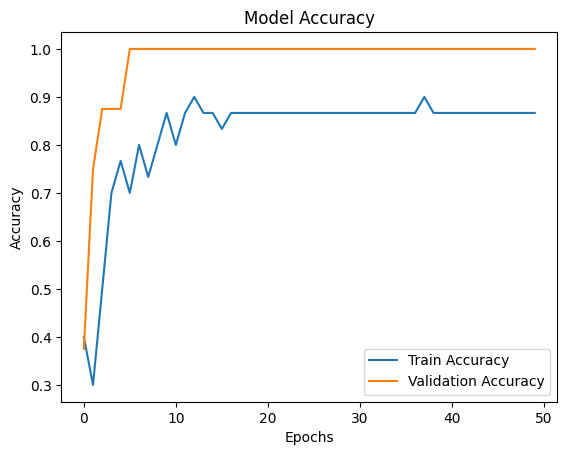

In [7]:
import matplotlib.pyplot as plt

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


Yes, a simpler model like logistic regression or linear regression (with a softmax function) can work for this task, especially if the relationships between the input features (Latitude, Longitude, SOG, COG, and Heading) and the Navigational Status are mostly linear.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Preprocess Data (Assuming 'data' DataFrame is already loaded and cleaned as above)
X = grouped.drop(columns=['Navigational status_first'])
y = grouped['Navigational status_first']

# Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.8
Classification Report:
                         precision    recall  f1-score   support

             At anchor       0.00      0.00      0.00         1
                Moored       0.00      0.00      0.00         1
Under way using engine       0.80      1.00      0.89         8

              accuracy                           0.80        10
             macro avg       0.27      0.33      0.30        10
          weighted avg       0.64      0.80      0.71        10



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-pa

Conclusion:

The model shows good performance for one of the classes but struggles significantly with class imbalance. Implementing methods like class balancing (via resampling or class weights), exploring cross-validation, and possibly switching to a more complex model should improve the model’s ability to classify all the categories accurately.